<a id="menu"></a>
- [1. Import Packages and Functions](#1)
- [2. Prepocess & Split the data](#2)
- [3. LSTNet Model & Evaluation function](#3)
- [4. Hyperparameter Tuning](#4)
- [5. Plot & Evaluate our Model](#5) 

# Import Packages and Functions <a id='1'></a>

In [241]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import random
from datetime import datetime
from collections import Counter
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import gluonts
from gluonts.dataset.common import ListDataset
import optuna

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess & Split the Data <a id='2'></a>

In [205]:
data_path = 'btc_1d_engineered_selected_features.csv'
bitcoin_df = pd.read_csv(data_path, parse_dates=['date'], index_col=0)
#bitcoin_df = bitcoin_df.drop('target',axis=1)
bitcoin_df.head()

,close,Volume BTC,Volume USD,5_day_vol,rsi_14_over_30,rsi_7_over_14,vol_ratio_30_over_150,7_day_vol,target
date,,,,,,,,,
2016-03-05,393.93,3085.475956,51406.334052,0.012628,0.464096,0.540899,0.566766,0.017885,0.021320
2016-03-06,401.50,364.144701,5927.630071,0.022186,0.540183,0.834013,0.572994,0.021320,0.023761
2016-03-07,412.04,2426.501107,41283.999299,0.026930,0.640948,0.771759,0.568524,0.023761,0.023934
2016-03-08,412.09,1368.555389,23430.264324,0.026990,0.779819,0.688480,0.568466,0.023934,0.022044
2016-03-09,411.00,3401.546586,58139.630286,0.023666,0.707895,0.923819,0.564374,0.022044,0.022505


In [228]:
# Normalize features
scaler = StandardScaler()
features = bitcoin_df.drop('target', axis=1)
labels = bitcoin_df['target']
features_scaled = scaler.fit_transform(features)

# Convert to PyTorch tensors
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).view(-1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_tensor, labels_tensor, test_size=0.2, random_state=42)

# add a channel dimension to make them 3D. we assume 1 timestep
X_train = X_train.unsqueeze(1)  # Adds a channel dimension, making it [batch_size, 1, sequence_length]
X_test = X_test.unsqueeze(1)    # Same for the test set

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([2049, 1, 8])
torch.Size([513, 1, 8])
torch.Size([2049, 1])
torch.Size([513, 1])


In [229]:
train_iter = iter(train_loader)
features, labels = next(train_iter)

print("Sample batch shape:", features.shape)
print("Label batch shape:", labels.shape)
print("First sample data:", features[0])
print("First label data:", labels[0])

Sample batch shape: torch.Size([64, 1, 8])
Label batch shape: torch.Size([64, 1])
First sample data: tensor([[-0.6299,  0.6207, -0.1319,  8.0271,  0.0276, -0.4944,  2.5191,  6.7789]])
First label data: tensor([0.1724])


[Back to Menu](#menu)

# Define LSTNet Model & Evaluation & Metric function <a id='3'></a>

In [208]:
# LSTNet modeling
class LSTNet(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size):
        super(LSTNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=hidden_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Switch from (batch, seq, features) to (batch, features, seq)
        x = self.relu(self.conv1(x))
        x = x.permute(2, 0, 1)  # Switch back to (seq, batch, features)
        output, _ = self.gru(x)
        output = self.fc(output[-1])
        return output

In [238]:
# Evaluation and Plot function
def evaluate_and_plot(model, test_loader):
    """
    This function evaluates the model using the provided DataLoader and plots the actual vs predicted values.
    
    Parameters:
    model (torch.nn.Module): The trained model to evaluate.
    data_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    predictions, actuals = [], []
    for features, labels in test_loader:
        with torch.no_grad():
            # Make predictions
            preds = model(features).cpu().numpy()
            # Extract actual values
            act = labels.cpu().numpy()
            # Append flattened results to the lists
            predictions.extend(preds.flatten())
            actuals.extend(act.flatten())

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.plot(actuals, color='red', label='Actual Data')
    plt.plot(predictions, label='Predicted Data', color='blue')
    plt.title('Actual vs Predicted Volatility')
    plt.xlabel('Sample')
    plt.ylabel('Target')
    plt.legend()
    plt.show()
    
    # Calculate metrics
    predictions_array, actuals_array = np.array(predictions), np.array(actuals)
    print("RMSE:", rmse(predictions_array, actuals_array))
    print("MAE:", mae(predictions_array, actuals_array))
    print("MAPE:", mape(predictions_array, actuals_array))
    print("Theil U Statistic:", theil_u_statistic(predictions_array, actuals_array))


In [231]:
# metric function
def rmse(predictions, actuals):
    return np.sqrt(((predictions - actuals) ** 2).mean())

def mae(predictions, actuals):
    return np.abs(predictions - actuals).mean()

def mape(predictions, actuals):
    return np.mean(np.abs((actuals - predictions) / actuals)) * 100

def theil_u_statistic(predictions, actuals):
    numerator = np.sqrt(((predictions - actuals) ** 2).mean())
    denominator = np.sqrt((predictions ** 2).mean()) + np.sqrt((actuals ** 2).mean())
    return numerator / denominator

[Back to Menu](#menu)

# Hyperparameter Tunning <a id='4'></a>

In [235]:
# Hyperparameter tuning 
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    hidden_size = trial.suggest_categorical('hidden_size', [20, 50, 100])

    model = LSTNet(input_channels=X_train.shape[2], hidden_size=hidden_size, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(10):  # Modify epochs based on your dataset size and training requirements
        for features, labels in train_loader:
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

    # Validation step to get loss for the Optuna study
    val_loss = 0
    for features, labels in test_loader:
        with torch.no_grad():
            output = model(features)
            loss = criterion(output, labels)
            val_loss += loss.item()
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters: ", study.best_trial.params)

[I 2024-05-06 01:30:24,959] A new study created in memory with name: no-name-7400d486-23f0-4675-afe1-fcd69a1449b0
[I 2024-05-06 01:30:25,213] Trial 0 finished with value: 0.00042298301650589565 and parameters: {'learning_rate': 0.011520350938457722, 'hidden_size': 20}. Best is trial 0 with value: 0.00042298301650589565.
[I 2024-05-06 01:30:25,429] Trial 1 finished with value: 0.0007089837438343238 and parameters: {'learning_rate': 0.0007359044904224036, 'hidden_size': 20}. Best is trial 0 with value: 0.00042298301650589565.
[I 2024-05-06 01:30:25,646] Trial 2 finished with value: 0.023461093893274665 and parameters: {'learning_rate': 2.1364155273970423e-05, 'hidden_size': 20}. Best is trial 0 with value: 0.00042298301650589565.
[I 2024-05-06 01:30:26,048] Trial 3 finished with value: 0.0006080946431825801 and parameters: {'learning_rate': 0.04478124265016229, 'hidden_size': 100}. Best is trial 0 with value: 0.00042298301650589565.
[I 2024-05-06 01:30:26,447] Trial 4 finished with value

Best hyperparameters:  {'learning_rate': 0.006717561915238624, 'hidden_size': 50}


[Back to Menu](#menu)

# Plot & Evaluate the Model <a id='5'></a>

In [236]:
# Train the best_model here using the best hyperparameters from above
best_model = LSTNet(input_channels=X_train.shape[2], hidden_size=study.best_params['hidden_size'], output_size=1)
best_model

LSTNet(
  (conv1): Conv1d(8, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (gru): GRU(50, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [214]:
# def evaluate_model(model, test_loader):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for data, targets in test_loader:
#             outputs = model(data)
#             loss = criterion(outputs, targets)
#             total_loss += loss.item()
#     return total_loss / len(test_loader)

# loss = evaluate_model(model, test_loader)
# print(f'Test Loss: {loss:.4f}')

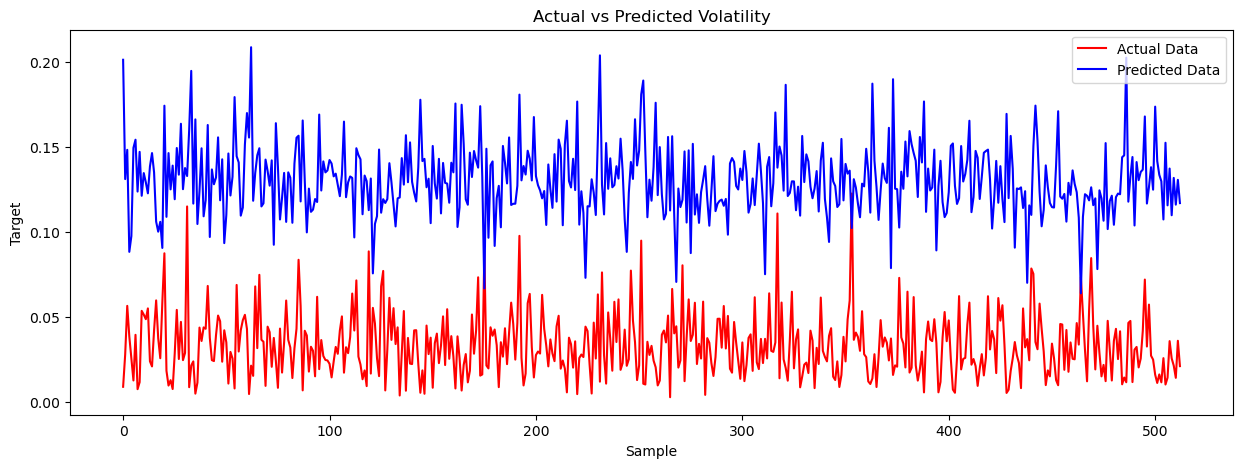

RMSE: 0.10223447
MAE: 0.09758311
MAPE: 523.9424705505371
Theil U Statistic: 0.60161465


In [239]:
# run evaluate and plot function
evaluate_and_plot(best_model, test_loader)

[Back to Menu](#menu)